In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [2]:
#load the dataset
df = pd.read_csv('outliersRemoved.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,2
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,2
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,2
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,3
4,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1762 non-null   object 
 1   Age                             1762 non-null   float64
 2   Height                          1762 non-null   float64
 3   Weight                          1762 non-null   float64
 4   family_history_with_overweight  1762 non-null   object 
 5   FAVC                            1762 non-null   object 
 6   FCVC                            1762 non-null   float64
 7   NCP                             1762 non-null   float64
 8   CAEC                            1762 non-null   object 
 9   SMOKE                           1762 non-null   object 
 10  CH2O                            1762 non-null   float64
 11  SCC                             1762 non-null   object 
 12  FAF                             17

### Label-encode class attr. and delete the class attr. from the data frame.

In [4]:
def prepareY(df):
    # extract Y and drop from dataframe
    Y = df['NObeyesdad']
    # encode class values as integers
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    return yencoder.transform(Y)


y = prepareY(df)  # label encode class attr.
df = df.drop(["NObeyesdad"], axis=1)  # drop the class attr.
#pd.DataFrame(y).head()

#### Separate each categorical and numerical so we could handle each one independently and transform the columns


In [5]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns

# use OrdinalEncoder() for our categorical columns and StandardScaler() for our numerical columns()
column_trans = ColumnTransformer(
    [('cat', OrdinalEncoder(), categorical_columns),
     ('num', StandardScaler(), numerical_columns)])
column_trans.fit(df)

X = column_trans.transform(df)  # declare X after transformations
# pd.DataFrame(X).head()

In [6]:
n_features = X.shape[1]  # get the number of fetures in X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# convert class attr to categorical
yhot = np_utils.to_categorical(y)
yhot_train = np_utils.to_categorical(y_train)
yhot_test = np_utils.to_categorical(y_test)

In [8]:
# input layer = no. of features = 16
# 2 hidden layers. each of size of input layer * 2
# output layer = size of target ( 7 categories) = 7

def baseline_model():

    model = Sequential()
    # first activation layer gets input from size n_features
    model.add(Dense(32, input_dim=n_features, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Softmax for multi-class classification - per 'Madrich Lemidha'
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
from sklearn.model_selection import KFold
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

# use KerasClassifier so we could convert our model and use kfold from sklearn
cmodel = KerasClassifier(build_fn=baseline_model, epochs=200,batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)


In [10]:
# evaluate our model on all of our dataset
result = cross_val_score(cmodel, X, yhot, cv=kfold)
print("Result should be around: %.2f%% (%.2f%%)" % (result.mean() * 100, result.std() * 100))

Metal device set to: Apple M1 Max


2022-06-14 19:30:55.528035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-14 19:30:55.528170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-14 19:30:55.606849: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-14 19:30:55.776415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:31:15.664067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:31:15.872994: I tensorflow/core/grappler/o

2022-06-14 19:32:36.712693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:32:36.940984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-06-14 19:32:57.828979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:32:58.064999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:33:18.826868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:33:19.045212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:33:39.869696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:33:40.077546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:34:00.848800: I tensorflow/core/grappler/optimizers/cust

Result should be around: 96.14% (1.60%)


2022-06-14 19:34:21.243583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
# Compile and evaluate model on training data
model = baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, yhot_train, validation_split=0.33,
                    epochs=200,batch_size=100, verbose=2)

Epoch 1/200


2022-06-14 19:34:37.245434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 - 1s - loss: 2.0305 - accuracy: 0.1186 - val_loss: 1.9918 - val_accuracy: 0.1302 - 516ms/epoch - 57ms/step
Epoch 2/200


2022-06-14 19:34:37.447399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 - 0s - loss: 1.9487 - accuracy: 0.1792 - val_loss: 1.9239 - val_accuracy: 0.2875 - 111ms/epoch - 12ms/step
Epoch 3/200
9/9 - 0s - loss: 1.8852 - accuracy: 0.3123 - val_loss: 1.8687 - val_accuracy: 0.3612 - 106ms/epoch - 12ms/step
Epoch 4/200
9/9 - 0s - loss: 1.8298 - accuracy: 0.3656 - val_loss: 1.8105 - val_accuracy: 0.4054 - 100ms/epoch - 11ms/step
Epoch 5/200
9/9 - 0s - loss: 1.7726 - accuracy: 0.3959 - val_loss: 1.7452 - val_accuracy: 0.4300 - 100ms/epoch - 11ms/step
Epoch 6/200
9/9 - 0s - loss: 1.7086 - accuracy: 0.4370 - val_loss: 1.6712 - val_accuracy: 0.4742 - 100ms/epoch - 11ms/step
Epoch 7/200
9/9 - 0s - loss: 1.6360 - accuracy: 0.4758 - val_loss: 1.5821 - val_accuracy: 0.4914 - 106ms/epoch - 12ms/step
Epoch 8/200
9/9 - 0s - loss: 1.5560 - accuracy: 0.5085 - val_loss: 1.4932 - val_accuracy: 0.5553 - 101ms/epoch - 11ms/step
Epoch 9/200
9/9 - 0s - loss: 1.4727 - accuracy: 0.5254 - val_loss: 1.4030 - val_accuracy: 0.5627 - 99ms/epoch - 11ms/step
Epoch 10/200
9/9 - 0s - loss:

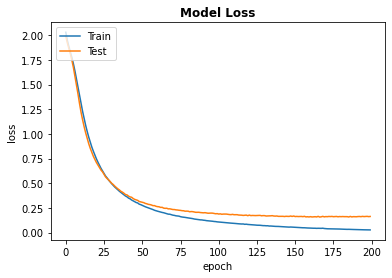

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', weight='bold')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# run an evaluation test set and see how we hold up with new data.
_, accuracy = model.evaluate(X_test, yhot_test)
print('Model Accuracy on new data: %.2f' % (accuracy * 100))

17/17 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 0.9546
Model Accuracy on new data: 95.46


In [14]:
# Make a prediction on all our data and see how we go.
y_pred = model.predict(X_test)
pred = np.argmax(y_pred, axis=1)
print(f'Model Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

17/17 [==============================] - 0s 2ms/step
Model Prediction Accuracy: 95.463138


2022-06-14 19:35:07.474587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [15]:
print(f'Number of classified: {(pred == y_test).sum()}')

Number of classified: 505


In [16]:
print(f'Number of misclassified: {(pred != y_test).sum()}')

Number of misclassified: 24


In [19]:
#ann_viz(model, title="Obesity Network", view=False, filename="test.pdf")
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)